# Variant Calling

In [1]:
import pandas as pd
import numpy as np

datapath = 'data/'

def read_vcf(filename):
    df = pd.read_csv(datapath + filename, sep='\t')
    
    # filter to separate indels from snp
    snp_only = df.apply(lambda row: len(row.REF)==1 and len(row.ALT)==1, axis=1)
    snp = df[snp_only]
    indels = df[~snp_only]
    
    print len(df), len(snp), len(indels)
    
    return snp, indels

### 1. read NIST.vcf

In [2]:
nist2_snp, nist2_indels = read_vcf('na12878-nist.chr2')
#nist3_snp, nist3_indels = read_vcf('na12878-nist.chr3')
nist2_snp.head()

373001 303275 69726


,CHROM,POS,REF,ALT,DP,ADR,ADA,GQ,LABEL
0,2,11320,G,A,19,0,19,57,PASS
1,2,13241,T,C,39,17,22,99,PASS
3,2,21888,A,C,37,0,37,99,FAIL
4,2,30762,A,G,46,0,46,99,FAIL
5,2,31926,T,C,31,0,31,93,FAIL


### 2. read garvan.vcf

In [3]:
#garv2_snp, garv2_indels = read_vcf('na12878-garvan.chr2')
garv3_snp, garv3_indels = read_vcf('na12878-garvan.chr3')
garv3_snp.head()

306338 249746 56592


,CHROM,POS,REF,ALT,DP,ADR,ADA,GQ,LABEL
0,3,60596,C,A,40,0,40,99,PASS
1,3,61044,T,C,34,0,34,99,PASS
2,3,61113,A,T,30,0,30,90,PASS
3,3,61495,A,G,49,24,25,99,PASS
4,3,61762,T,A,41,17,24,99,PASS


### 3. NIST_train = (garvan if in NIST.vcf - NIST_chr3)

The NIST dataset doesn't contain the AD feature, so we need to get that column from the Garvan dataset, using an inner join.

In [4]:
#ng_inner = garv_train.merge(nist_train, how='inner', copy=True, indicator=True, 
#                             fields=['CHROM', 'POS', 'REF', 'ALT'])

nist_train = nist2_snp
#nist_test = nist3_snp

### 4. garvan_train = split(garvan.vcf - garban_chr3)

In [5]:
#garv_train = garv2_snp
garv_test = garv3_snp

### 5. est_neg  = (garvan_train - NIST_train),  (change to fail)

In [6]:
"""joined = garv_train.merge(nist_train, how='left', on=['CHROM', 'POS', 'REF', 'ALT'], 
                             copy=True, indicator=True)
grouped = joined.groupby('_merge')
for g in grouped.groups:
    print g
joined.head()"""

"joined = garv_train.merge(nist_train, how='left', on=['CHROM', 'POS', 'REF', 'ALT'], \n                             copy=True, indicator=True)\ngrouped = joined.groupby('_merge')\nfor g in grouped.groups:\n    print g\njoined.head()"

In [7]:
"""est_neg = joined[['CHROM_x', 'POS', 'REF', 'ALT', 'DP_x', 'ADR_x', 'ADA_x', 'GQ_x', 'LABEL_x']][joined._merge!='left_only']
est_neg.columns = ['CHROM', 'POS', 'REF', 'ALT', 'DP', 'ADR', 'ADA', 'GQ', 'LABEL']
est_neg['LABEL'] = 'FAIL'
est_neg.head()
joined = None"""

"est_neg = joined[['CHROM_x', 'POS', 'REF', 'ALT', 'DP_x', 'ADR_x', 'ADA_x', 'GQ_x', 'LABEL_x']][joined._merge!='left_only']\nest_neg.columns = ['CHROM', 'POS', 'REF', 'ALT', 'DP', 'ADR', 'ADA', 'GQ', 'LABEL']\nest_neg['LABEL'] = 'FAIL'\nest_neg.head()\njoined = None"

### 6. train = nist_train + est_neg

In [8]:
"""train = pd.concat([nist_train, est_neg])
est_neg = None"""
train = nist_train
test = garv_test

### 7. classifier = model.fit(train)

In [9]:
y_train = np.array(train['LABEL']=='PASS')
print len(y_train), sum(y_train)

303275 232395


In [10]:
def extract_features(obs, cols):
    bases = ['A', 'C', 'G', 'T']
    X = np.ndarray(shape=(len(obs), len(cols) + 2*(len(['A', 'C', 'G', 'T'])-1)))
    i = 0
    for ix in obs.index:
        row = obs.ix[ix]
        rowl = []
        for c in cols:
            if c in ['REF', 'ALT']:  
                for n in bases:
                    v = 1.0 if n==row[c] else 0.0
                    rowl.append(v)
            else:
                rowl.append(row[c])
                
        X[i,:] = rowl
        i += 1
        
    feature_names = []
    for c in cols:
        if c in ['REF', 'ALT']:  
            for n in bases:
                feature_names.append(c + '_' + n)
        else:
            feature_names.append(c) 
    
    return X, feature_names 

In [11]:
X_train1, feature_names1 = extract_features(train, ['REF', 'ALT', 'DP', 'ADR', 'ADA', 'GQ'])
X_train1[0:1,:]

array([[  0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,  19.,   0.,  19.,
         57.]])

In [12]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit_transform(X_train1, y_train)
print feature_names1
print classifier.coef_

['REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T', 'DP', 'ADR', 'ADA', 'GQ']
[[-0.54622035 -0.43322379 -0.46548141 -0.53355778 -0.52518072 -0.45940458
  -0.45596771 -0.53793031 -0.14113673  0.11606624  0.14420675  0.04589291]]


/home/adrian/.conda/envs/py27/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


### 8. Eval

####    8.1   -  test = nist3 + changed_to_fail(garvan3 - nist3) 

In [13]:
X_test1, feature_names = extract_features(garv_test, ['REF', 'ALT', 'DP', 'ADR', 'ADA', 'GQ'])
X_test1[0:1,:]

array([[  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,  40.,   0.,  40.,
         99.]])

In [14]:
y_test = np.array(garv_test['LABEL']=='PASS')
print len(y_test), sum(y_test), len(y_test) - sum(y_test), "Majority Class Score: ", sum(y_test)/float(len(y_test))

249746 245719 4027 Majority Class Score:  0.983875617628


####    8.2   -  pred_y = model.predict(test.X)

In [15]:
y_pred = classifier.predict(X_test1)

####    8.3 - Accuracy Score 

In [16]:
classifier.score(X_test1, y_test)

0.96238578395649976

In [17]:
feature_names1 = None
X_test1 = None
classifier = None

### Classification Metrics

 #### Confusion Matrix

 $C_{i, j}$ is equal to the number of observations known to be in group i but predicted to be in group j.

In [18]:
from sklearn.metrics import confusion_matrix

def class_error(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    label_dict = {0: '0-FAIL', 1:'1-PASS'}
    print '      ', label_dict.values()
    for i in range(len(cm[:,0])):
        print 'True', label_dict[i], cm[i,:]
    
    return cm

cm = class_error(y_test, y_pred)

       ['0-FAIL', '1-PASS']
True 0-FAIL [ 325 3702]
True 1-PASS [  5692 240027]


#### Precission - Recall

In [19]:
def precission_recall(cm):
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    acu = (tp+tn)/float(tp+fp+tn+fn)
    pre = (tp)/float(tp+fp)
    rec = (tp)/float(tp+fn)
    print "Accuracy   = %.4f" % acu
    print "Precission (specificity) = %.4f" % pre
    print "Recall     (sensitivity) = %.4f" % rec
     
    return pre, rec

p, r = precission_recall(cm)

Accuracy   = 0.9624
Precission (specificity) = 0.9848
Recall     (sensitivity) = 0.9768


#### F1 score (also F-score or F-measure) 
The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall:

$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

In [20]:
def F_measure(pre, rec):
    F_measure = 2 * pre * rec / (pre + rec)
    print "F_measure = %.4f" % F_measure
    return F_measure

F1 = F_measure(p, r)

F_measure = 0.9808


## Adding Position as Feature

In [21]:
def get_features(df, name):
    y = np.array(df['LABEL']=='PASS')
    print 'y_'+name, len(y), sum(y), (len(y) - sum(y))
    
    X, feature_names = extract_features(df, ['POS', 'REF', 'ALT', 'DP', 'ADR', 'ADA', 'GQ'])
    print feature_names
    for i in range(5):  
        print [int(xi) for xi in X[i,:]]  
    
    return X, y, feature_names

In [22]:
X_train, y_train, feature_names = get_features(train, 'train')

y_train 303275 232395 70880
['POS', 'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T', 'DP', 'ADR', 'ADA', 'GQ']
[11320, 0, 0, 1, 0, 1, 0, 0, 0, 19, 0, 19, 57]
[13241, 0, 0, 0, 1, 0, 1, 0, 0, 39, 17, 22, 99]
[21888, 1, 0, 0, 0, 0, 1, 0, 0, 37, 0, 37, 99]
[30762, 1, 0, 0, 0, 0, 0, 1, 0, 46, 0, 46, 99]
[31926, 0, 0, 0, 1, 0, 1, 0, 0, 31, 0, 31, 93]


In [23]:
X_test, y_test, _ = get_features(test, 'test')

y_test 249746 245719 4027
['POS', 'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T', 'DP', 'ADR', 'ADA', 'GQ']
[60596, 0, 1, 0, 0, 1, 0, 0, 0, 40, 0, 40, 99]
[61044, 0, 0, 0, 1, 0, 1, 0, 0, 34, 0, 34, 99]
[61113, 1, 0, 0, 0, 0, 0, 0, 1, 30, 0, 30, 90]
[61495, 1, 0, 0, 0, 0, 0, 1, 0, 49, 24, 25, 99]
[61762, 0, 0, 0, 1, 1, 0, 0, 0, 41, 17, 24, 99]


In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Create classifiers
lr = LogisticRegression(random_state=1)
gnb = GaussianNB()
svc = LinearSVC(C=1.0, random_state=1)
rfc = RandomForestClassifier(n_estimators=100, random_state=1)

In [25]:
def eval_clf(clf, X_test, y_test):
    print "Majority Class Accuracy: ", sum(y_test)/float(len(y_test))    
    y_pred = clf.predict(X_test) 
    cm = class_error(y_test, y_pred)
    p, r = precission_recall(cm)
    F1 = F_measure(p, r)

In [26]:
def train_clf(clf, X_train, y_train, X_test, y_test, name, feature_names):
    clf.fit(X_train, y_train) 
    if name == 'Logistic':
        print feature_names
        print clf.coef_
        print
    print 'Eval metrics on the training data:'
    eval_clf(clf, X_train, y_train)
    print
    print 'Eval metrics on the test data'
    eval_clf(clf, X_test, y_test)


In [27]:
for clf, name in [(lr, 'Logistic'),
                  (rfc, 'Random Forest'),
                  (svc, 'Support Vector Classification'),
                  (gnb, 'Naive Bayes')]:
    print '\n------------------------------------------\nTraining ', name    
    train_clf(clf, X_train, y_train, X_test, y_test, name, feature_names)


------------------------------------------
Training  Logistic
['POS', 'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T', 'DP', 'ADR', 'ADA', 'GQ']
[[  7.41503786e-09   2.36169827e-17   2.70944619e-17   2.60654097e-17
    2.38443720e-17   2.44196349e-17   2.57487877e-17   2.56206998e-17
    2.48321039e-17   3.75730195e-15   8.69774436e-16   2.89227931e-15
    1.04261202e-14]]

Eval metrics on the training data:
Majority Class Accuracy:  0.766284725084
       ['0-FAIL', '1-PASS']
True 0-FAIL [    0 70880]
True 1-PASS [     0 232395]
Accuracy   = 0.7663
Precission (specificity) = 0.7663
Recall     (sensitivity) = 1.0000
F_measure = 0.8677

Eval metrics on the test data
Majority Class Accuracy:  0.983875617628
       ['0-FAIL', '1-PASS']
True 0-FAIL [   0 4027]
True 1-PASS [     0 245719]
Accuracy   = 0.9839
Precission (specificity) = 0.9839
Recall     (sensitivity) = 1.0000
F_measure = 0.9919

------------------------------------------
Training  Random Forest
Eval me

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_feature_importance(forest, X, feature_names):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    
    plt.bar(range(X.shape[1]), importances, color="r", yerr=std[indices], align="center")  
    plt.xticks(range(X.shape[1]), feature_names)

    """    
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    xheaders = [feature_names[f] for f in indices]   
    plt.xticks(range(X.shape[1]), xheaders)
    """

    plt.xlim([-1, X.shape[1]])
    plt.xticks(rotation=60)
    plt.show()
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%2d. feature %2d - %6s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))


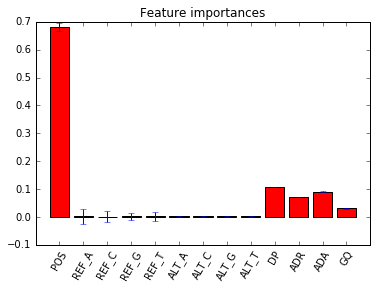

Feature ranking:
 1. feature  0 -    POS (0.680897)
 2. feature  9 -     DP (0.108317)
 3. feature 11 -    ADA (0.090731)
 4. feature 10 -    ADR (0.071202)
 5. feature 12 -     GQ (0.031488)
 6. feature  8 -  ALT_T (0.002273)
 7. feature  5 -  ALT_A (0.002268)
 8. feature  6 -  ALT_C (0.002260)
 9. feature  3 -  REF_G (0.002219)
10. feature  7 -  ALT_G (0.002171)
11. feature  4 -  REF_T (0.002160)
12. feature  1 -  REF_A (0.002143)
13. feature  2 -  REF_C (0.001872)


In [79]:
plot_feature_importance(rfc, X_train, feature_names)